# Project ARI3129 - Object Detection & Localisation using Yolov8 *(Jupyter Notebook #2)*
---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Automated Dataset Management with Roboflow and Folder Organization

This script automates the process of managing a dataset using Roboflow. It creates necessary directories, checks for installed dependencies, installs them if missing, and downloads the dataset. It also organizes the dataset into a structured folder hierarchy, ensuring everything is ready for further use.

In [69]:
import os
import subprocess
import shutil

# Constants for colored output
COLORS = {
    "green": "\033[92m",  # Green text
    "red": "\033[91m",    # Red text
    "reset": "\033[0m"    # Reset to default color
}

# Define the path to the Versions folder and the target subfolder
versions_path = os.path.abspath(os.path.join("..", "Versions"))
target_subfolder = os.path.join(versions_path, "MDD-AFL-Yolov8")

# Check if the Versions folder exists, if not, create it
if not os.path.exists(versions_path):
    os.makedirs(versions_path)
    print(f"[{COLORS['green']}✔{COLORS['reset']}] Folder created at: {versions_path}")

# Check if the MDD-AFL-Yolov8 subfolder exists
if os.path.exists(target_subfolder):
    print(f"[{COLORS['green']}✔{COLORS['reset']}] The subfolder '{target_subfolder}' already exists. Skipping download!")
else:
    # Check if roboflow is installed
    if importlib.util.find_spec("roboflow") is not None:                                                                                                        # type: ignore
        print(f"[{COLORS['green']}✔{COLORS['reset']}] Roboflow is already installed!")
    else:
        # Install roboflow using pip
        try:
            subprocess.check_call(["pip", "install", "roboflow"])
            print(f"[{COLORS['green']}✔{COLORS['reset']}] Roboflow successfully installed!")
        except subprocess.CalledProcessError as e:
            print(f"[{COLORS['red']}✖{COLORS['reset']}]Failed to install Roboflow. Please check your setup.")
            raise e

    # Import and use Roboflow
    from roboflow import Roboflow                                                                                                                               # type: ignore

    # Prompt the user for their API key
    print("Please enter your Roboflow API key to download the dataset...")
    api_key = input("Please enter your Roboflow API key: ")

    # Initialize Roboflow with the provided API key
    rf = Roboflow(api_key=api_key)

    # Retrieve project and version
    project = rf.workspace("advanced-cv").project("maltese-domestic-dataset")
    version = project.version(1)

    # Download the dataset
    dataset = version.download("yolov8")

    current_folder = os.getcwd()  # Get the current working directory
    original_folder = os.path.join(current_folder, "Maltese-Domestic-Dataset--1")
    renamed_folder = os.path.join(current_folder, "MDD-AFL-Yolov8")
    target_folder = os.path.join(versions_path, "MDD-AFL-Yolov8")

    # Check if the original folder exists
    if os.path.exists(original_folder):
        # Rename the folder
        os.rename(original_folder, renamed_folder)

        # Move the renamed folder to ../Versions/
        shutil.move(renamed_folder, target_folder)
        print(f"[{COLORS['green']}✔{COLORS['reset']}] Folder downloaded to: {target_folder}")
    else:
        print(f"[{COLORS['red']}✖{COLORS['reset']}]Folder '{original_folder}' does not exist. No action taken.")


[✔] The subfolder '/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8' already exists. Skipping download!


## Automated Library Installer in Python

This script automates checking and installing libraries from a JSON file. It verifies installations, installs missing libraries via `pip`, and provides clear, colored output for success or errors. With built-in error handling and preloaded common libraries, it simplifies dependency management in Python projects.

In [70]:
import json
import importlib.util

# Path to the JSON file
lib_file_path = os.path.join("..", "Libraries", "Task2_AFL_Lib.json")

# Read the libraries from the JSON file
try:
    with open(lib_file_path, 'r') as file:
        libraries = json.load(file)
except FileNotFoundError:
    print(f"{COLORS['red']}Error: Library file not found at {lib_file_path}{COLORS['reset']}")
    exit(1)
except json.JSONDecodeError:
    print(f"{COLORS['red']}Error: Failed to decode JSON from the library file.{COLORS['reset']}")
    exit(1)

# Function to check and install libraries
def check_and_install_libraries(libraries):
    for lib, import_name in libraries.items():
        # Check if the library is installed by checking its module spec
        if importlib.util.find_spec(import_name) is not None:
            print(f"[{COLORS['green']}✔{COLORS['reset']}] Library '{lib}' is already installed.")
        else:
            # If the library is not found, try to install it
            print(f"[{COLORS['red']}✖{COLORS['reset']}] Library '{lib}' is not installed. Installing...")
            try:
                subprocess.check_call(["pip", "install", lib])
                print(f"[{COLORS['green']}✔{COLORS['reset']}] Successfully installed '{lib}'.")
            except subprocess.CalledProcessError:
                print(f"[{COLORS['red']}✖{COLORS['reset']}] Failed to install '{lib}'. Please install it manually.")


# Execute the function to check and install libraries
check_and_install_libraries(libraries)

# Import necessary libraries 
import time
import torch
import random
import cv2                                                                                                                                                      #type: ignore
import matplotlib.pyplot as plt                                                                                                                                 #type: ignore
import seaborn as sns                                                                                                                                           #type: ignore
import numpy as np                                                                                                                                              #type: ignore
import matplotlib.patches as patches                                                                                                                            #type: ignore
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm                                                                                                                                           #type: ignore
from ultralytics import YOLO                                                                                                                                    #type: ignore

[✔] Library 'opencv-python' is already installed.
[✔] Library 'matplotlib' is already installed.
[✔] Library 'tqdm' is already installed.
[✔] Library 'ultralytics' is already installed.
[✔] Library 'torch' is already installed.


In [71]:
# Determine the available device: CUDA, MPS, or CPU.
def determine_device():
    if torch.cuda.is_available():
        device = "cuda"
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    elif torch.backends.mps.is_available():
        device = "mps"
        print("Using MPS (Metal Performance Shaders) for acceleration.")
    else:
        device = "cpu"
        print("Using CPU. Consider enabling GPU or MPS for faster training.")
    return device

In [72]:
# Path to data.yaml
data_yaml_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "Versions", "MDD-AFL-Yolov8", "data.yaml")

# Hyperparameters
epochs = 50
imgsz = 640
batch_size = 8
experiment_name = "MDD-AFL-Yolov8_v2"

In [ ]:
# Determine the device
device = determine_device()

# Timer start
start_time = time.time()

# Create or load a YOLOv8 model (from scratch)
try:
    model = YOLO("yolov8l.yaml")  # specify architecture (ex: yolov8n.yaml, yolov8l.yaml)
except FileNotFoundError:
    print("Error: YOLOv8 configuration file 'yolov8l.yaml' not found. Check your setup.")
    raise

# Train
try:
    model.train(
        data=data_yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=batch_size,
        name=experiment_name,
        pretrained=False,  # to train from scratch
        device=device  # Set the appropriate device
    )
except Exception as e:
    print(f"Error during training: {e}")
    raise

# Timer end
end_time = time.time()
print(f"Training completed in {end_time - start_time:.2f} seconds.")

# Evaluate
try:
    metrics = model.val()
    print("Validation Metrics:", metrics)
    
    # Save metrics to a file
    metrics_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "Versions", "MDD-AFL-Yolov8", "validation_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)
    print(f"Validation metrics saved to: {metrics_path}")
except Exception as e:
    print(f"Error during validation: {e}")
    raise


In [9]:
# Path to data.yaml (relative to Yolov8_AFL.ipynb)
data_yaml_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), "Versions", "MDD-AFL-Yolov8", "data.yaml")
#data_yaml_path = "/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/data.yaml"

# Create or load a YOLOv8 model (from scratch)
model = YOLO("yolov8n.yaml")  # specify your chosen architecture (e.g., yolov8n.yaml)

# Train
model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=640,
    batch=8,
    name="MDD-AFL-Yolov8_v1",
    pretrained=False  # to train from scratch
)

# Evaluate
metrics = model.val()
print("Validation Metrics:", metrics)

Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/data.yaml, epochs=50, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=MDD-AFL-Yolov8_v1, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save

train: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/train/labels... 748 images, 0 backgrounds, 0 corrupt: 100%|██████████| 748/748 [00:21<00:00, 35.01it/s]  

train: New cache created: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/train/labels.cache



val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:17<00:00,  3.89it/s]

val: New cache created: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache


Plotting labels to runs/detect/MDD-AFL-Yolov8_v1/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/MDD-AFL-Yolov8_v1
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      3.485      4.524       4.19         29        640: 100%|██████████| 94/94 [06:41<00:00,  4.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]

                   all         70        228   0.000499     0.0507   0.000319   9.31e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50         0G      3.311      4.191      3.864         28        640: 100%|██████████| 94/94 [07:15<00:00,  4.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:25<00:00,  5.05s/it]

                   all         70        228      0.257     0.0915    0.00318    0.00089



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50         0G      3.214      3.904      3.506         11        640: 100%|██████████| 94/94 [07:21<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:27<00:00,  5.54s/it]

                   all         70        228     0.0165      0.177    0.00831    0.00283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         0G       3.09      3.854        3.3         63        640: 100%|██████████| 94/94 [07:09<00:00,  4.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:31<00:00,  6.37s/it]

                   all         70        228     0.0177      0.098     0.0129    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50         0G      2.962      3.616      3.107         31        640: 100%|██████████| 94/94 [07:06<00:00,  4.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:28<00:00,  5.60s/it]

                   all         70        228      0.172     0.0926     0.0694     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         0G      2.747      3.517      2.953         13        640: 100%|██████████| 94/94 [07:21<00:00,  4.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:30<00:00,  6.19s/it]

                   all         70        228      0.458      0.134     0.0905     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         0G      2.659      3.356      2.849         20        640: 100%|██████████| 94/94 [07:04<00:00,  4.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.83s/it]

                   all         70        228      0.341      0.174     0.0983     0.0314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50         0G      2.543      3.137      2.756         33        640: 100%|██████████| 94/94 [06:04<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.79s/it]

                   all         70        228      0.347      0.236      0.106      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         0G      2.401      3.063      2.651         21        640: 100%|██████████| 94/94 [06:35<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.72s/it]

                   all         70        228      0.239      0.168      0.137     0.0484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50         0G      2.285      2.983      2.569         13        640: 100%|██████████| 94/94 [06:31<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.398      0.263      0.174     0.0727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50         0G      2.266      2.922       2.54         41        640: 100%|██████████| 94/94 [06:44<00:00,  4.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]

                   all         70        228      0.509       0.23      0.178     0.0754



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50         0G      2.157      2.786      2.458         21        640: 100%|██████████| 94/94 [05:48<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.60s/it]

                   all         70        228      0.583      0.236      0.233     0.0957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         0G      2.154      2.714      2.413         21        640: 100%|██████████| 94/94 [06:01<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.615      0.264      0.238      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50         0G      2.125      2.742      2.404         31        640: 100%|██████████| 94/94 [05:49<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.87s/it]

                   all         70        228      0.515      0.248      0.222      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50         0G      2.101      2.643      2.335         12        640: 100%|██████████| 94/94 [05:48<00:00,  3.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]

                   all         70        228      0.425      0.334      0.252      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50         0G      2.015      2.541      2.287         45        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.71s/it]

                   all         70        228      0.249       0.33      0.215      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G      2.006      2.507      2.263         29        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.62s/it]

                   all         70        228      0.459      0.357      0.338      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         0G      1.963      2.459      2.241         19        640: 100%|██████████| 94/94 [05:50<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.65s/it]

                   all         70        228      0.381      0.351      0.269      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50         0G      1.959      2.442      2.222         26        640: 100%|██████████| 94/94 [05:47<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.61s/it]

                   all         70        228      0.403      0.328      0.256       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         0G      1.922      2.413      2.189         24        640: 100%|██████████| 94/94 [05:52<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.367      0.289      0.284      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         0G      1.917      2.377      2.178         28        640: 100%|██████████| 94/94 [05:44<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.405      0.383      0.301      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50         0G      1.894      2.349       2.15         18        640: 100%|██████████| 94/94 [05:43<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.59s/it]

                   all         70        228      0.499      0.362       0.34      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50         0G      1.856      2.316      2.157          4        640: 100%|██████████| 94/94 [05:37<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.53s/it]

                   all         70        228      0.511       0.38      0.317      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50         0G       1.89      2.305      2.148         22        640: 100%|██████████| 94/94 [05:43<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.478      0.358      0.289      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         0G      1.873      2.266      2.126         42        640: 100%|██████████| 94/94 [06:04<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.672      0.305      0.335      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50         0G      1.864      2.209      2.111         26        640: 100%|██████████| 94/94 [05:45<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.521      0.383      0.363      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50         0G      1.798      2.171      2.071         38        640: 100%|██████████| 94/94 [05:47<00:00,  3.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.513      0.372      0.382      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50         0G      1.794      2.114      2.063         43        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.462      0.417      0.399       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         0G      1.792      2.135      2.049         41        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.494      0.419      0.369      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50         0G        1.8      2.154      2.063         15        640: 100%|██████████| 94/94 [05:54<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.628      0.403      0.406      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         0G      1.791      2.172       2.04         15        640: 100%|██████████| 94/94 [05:44<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.475      0.429      0.392      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50         0G      1.748      2.074      2.034         26        640: 100%|██████████| 94/94 [05:38<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.515      0.409      0.387      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         0G      1.755      2.084      2.027         13        640: 100%|██████████| 94/94 [05:42<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.525      0.428      0.411      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50         0G      1.729      2.047      2.011         21        640: 100%|██████████| 94/94 [05:40<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.576      0.414      0.414      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50         0G      1.728      1.982      1.993         29        640: 100%|██████████| 94/94 [05:53<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]

                   all         70        228      0.492      0.417      0.401       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50         0G      1.749      2.046      2.014         38        640: 100%|██████████| 94/94 [05:40<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.64s/it]

                   all         70        228      0.514      0.438      0.434      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         0G      1.706      1.976      1.958         31        640: 100%|██████████| 94/94 [05:41<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.75s/it]

                   all         70        228      0.616      0.422      0.431      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50         0G      1.719       1.98      1.974         12        640: 100%|██████████| 94/94 [05:30<00:00,  3.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]

                   all         70        228      0.567       0.45      0.429      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50         0G      1.667      1.905      1.939         28        640: 100%|██████████| 94/94 [05:31<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]

                   all         70        228      0.619      0.425      0.436       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50         0G      1.694      1.944      1.963         17        640: 100%|██████████| 94/94 [05:43<00:00,  3.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]

                   all         70        228      0.652      0.379       0.45      0.269


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50         0G      1.591      1.921      1.905          8        640: 100%|██████████| 94/94 [06:26<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:23<00:00,  4.70s/it]

                   all         70        228      0.592      0.369      0.429      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         0G      1.564      1.813      1.891          8        640: 100%|██████████| 94/94 [05:49<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.523      0.489      0.459      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50         0G      1.526      1.724      1.859         10        640: 100%|██████████| 94/94 [05:40<00:00,  3.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.555      0.444      0.433      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50         0G      1.531      1.718      1.867         15        640: 100%|██████████| 94/94 [05:40<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228       0.59      0.478      0.472      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.521      1.692      1.849         21        640: 100%|██████████| 94/94 [05:37<00:00,  3.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.662      0.433      0.473      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50         0G      1.488      1.634      1.821         20        640: 100%|██████████| 94/94 [05:39<00:00,  3.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.558      0.497      0.493      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50         0G      1.497      1.658      1.836         11        640: 100%|██████████| 94/94 [05:26<00:00,  3.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.54s/it]

                   all         70        228      0.616      0.475      0.473      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50         0G      1.511      1.632      1.822         23        640: 100%|██████████| 94/94 [05:36<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.52s/it]

                   all         70        228      0.706      0.434       0.48      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         0G      1.474      1.617      1.802         10        640: 100%|██████████| 94/94 [05:35<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

                   all         70        228      0.508      0.533      0.487      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50         0G      1.474       1.62      1.819         16        640: 100%|██████████| 94/94 [05:33<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]

                   all         70        228       0.49      0.531      0.495      0.303



50 epochs completed in 5.343 hours.
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v1/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/MDD-AFL-Yolov8_v1/weights/best.pt, 6.3MB

Validating runs/detect/MDD-AFL-Yolov8_v1/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:24<00:00,  4.90s/it]


                   all         70        228      0.493      0.534      0.495      0.303
           Mixed Waste         20         67      0.497      0.517      0.514      0.307
         Organic Waste         26         53      0.499      0.585      0.474      0.281
           Other Waste         23         56      0.454      0.149      0.199        0.1
   Recyclable Material         25         52      0.521      0.885      0.794      0.525
Speed: 2.5ms preprocess, 333.4ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v1
Ultralytics 8.3.58 🚀 Python-3.11.1 torch-2.3.1 CPU (Apple M2)
YOLOv8n summary (fused): 168 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Versions/MDD-AFL-Yolov8/valid/labels.cache... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:14<00:00,  1.60s/it]


                   all         70        228      0.493      0.534      0.495      0.303
           Mixed Waste         20         67      0.497      0.517      0.514      0.307
         Organic Waste         26         53      0.499      0.585      0.474      0.281
           Other Waste         23         56      0.454      0.149      0.199        0.1
   Recyclable Material         25         52      0.521      0.885      0.794      0.525
Speed: 2.3ms preprocess, 191.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/MDD-AFL-Yolov8_v12
Validation Metrics: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x3340edad0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.0030

In [12]:
def load_model(weights_path):
    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found at {weights_path}.")
    return YOLO(weights_path)

def load_image(image_path):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found at {image_path}.")
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [13]:
def display_images_side_by_side(original, predicted, titles=("Original Image", "Predicted Image with Bounding Boxes")):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title(titles[0])
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(predicted)
    plt.title(titles[1])
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [55]:
def analyze_detections(results, model):
    # Get detected boxes and classes
    boxes = results[0].boxes  # Bounding box tensor
    num_objects = len(boxes)  # Total number of detected objects
    
    if num_objects == 0:
        print("No (0) objects detected in the image.")
        return
    
    # Extract class IDs and confidence scores
    class_ids = boxes.cls.cpu().numpy()
    confidences = boxes.conf.cpu().numpy()
    
    # Map class IDs to class names using model's class names
    class_names = [model.names[int(cls_id)] for cls_id in class_ids]
    
    # Count occurrences of each class
    class_counts = {}
    for class_name in class_names:
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    # Display analytics
    print("\n=== Image Analytics ===")
    print(f"Total Objects Detected: {num_objects}")
    print("Object Breakdown:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count}")
    print("Confidence Scores:")
    for i, (class_name, confidence) in enumerate(zip(class_names, confidences)):
        print(f"  {i + 1}. {class_name} - Confidence: {confidence:.2f}")

Selected test image: /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Jupyter Notebooks/../Dataset/Online/ARI3129_Online_3.jpeg
Using MPS (Metal Performance Shaders) for acceleration.

image 1/1 /Users/afl/Documents/University/Year 3/Lectures/SEM1/Advanced CV/Assignments/ARI3129-MDD/Jupyter Notebooks/../Dataset/Online/ARI3129_Online_3.jpeg: 352x640 3 Organic Wastes, 2 Recyclable Materials, 635.0ms
Speed: 23.2ms preprocess, 635.0ms inference, 170.7ms postprocess per image at shape (1, 3, 352, 640)


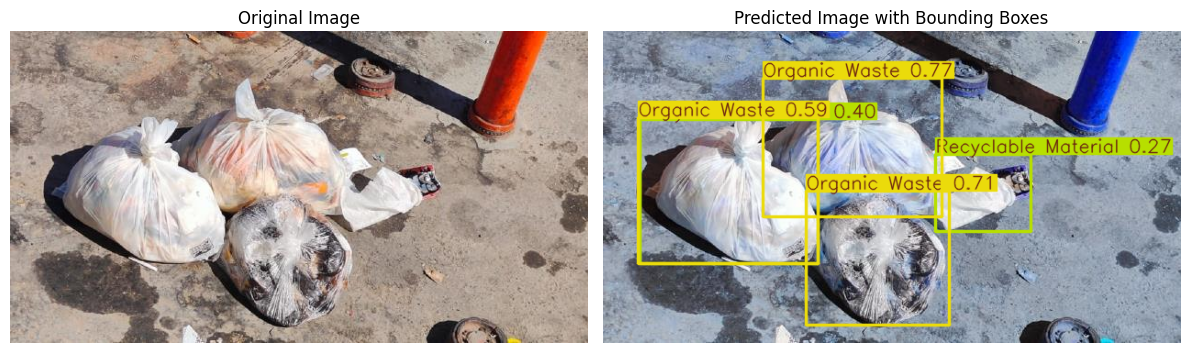


=== Image Analytics ===
Total Objects Detected: 5
Object Breakdown:
  - Organic Waste: 3
  - Recyclable Material: 2
Confidence Scores:
  1. Organic Waste - Confidence: 0.77
  2. Organic Waste - Confidence: 0.71
  3. Organic Waste - Confidence: 0.59
  4. Recyclable Material - Confidence: 0.40
  5. Recyclable Material - Confidence: 0.27


{'num_objects': 5,
 'class_counts': {'Organic Waste': 3, 'Recyclable Material': 2},
 'confidences': array([    0.77165,     0.71439,     0.58584,      0.3977,     0.27097], dtype=float32),
 'bounding_box_sizes': [29454.867, 22867.195, 30976.58, 30422.816, 8775.21],
 'class_names': ['Organic Waste',
  'Organic Waste',
  'Organic Waste',
  'Recyclable Material',
  'Recyclable Material']}

In [67]:
# Paths
weights_path = os.path.join(os.getcwd(), "runs", "detect", "MDD-AFL-Yolov8_v1", "weights", "best.pt")
# test_folder_path = os.path.join(os.getcwd(), "..", "Test")
test_folder_path = os.path.join(os.getcwd(), "..", "Dataset", "Online")

# Select a random image from the 'Test' folder
if not os.path.exists(test_folder_path):
    raise FileNotFoundError(f"Folder not found at {test_folder_path}.")
test_images = [img for img in os.listdir(test_folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
if not test_images:
    raise ValueError(f"No valid image files found in {test_folder_path}.")
test_image_path = os.path.join(test_folder_path, random.choice(test_images))
print(f"Selected test image: {test_image_path}")

# Determine the device
device = determine_device()

# Load the model
model = load_model(weights_path)

# Predict on the selected test image
results = model.predict(source=test_image_path, device=device)

# Load the original and predicted images
original_image = load_image(test_image_path)
predicted_image = results[0].plot()  # Get the image with bounding boxes

# Display images side-by-side
display_images_side_by_side(original_image, predicted_image)

# Provide analytics of detections
analyze_detections(results, model)
